# Glaucoma Dataset

Glaucoma dataset이 어떻게 구성되어 있는지 먼저 확인합니다. 직접 시각화하여 각각의 파일을 확인하고 어떤 task를 진행할지 결정합니다. 
아래의 목차는 구현의 전체적인 순서입니다.

1. 구성된 이미지 및 파일 시각화
2. train data, label 데이터 확인
3. task 설정 및 conjecture 생각하기
4. 결과 확인 및 해석
5. 결론 및 시사점 도출

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import KFold
import copy

class GlaucomaDataset:
    def __init__(self, root_dir, split='train', output_size=(256,256)):
        self.output_size = output_size
        self.root_dir = root_dir
        self.split = split
        self.images = []
        self.image_filenames = []
        self.segs = [] # GT - OC/OD
        self.gt_images = [] # GT - removed images 
        self.src_mask = []

        # Load data index
        for direct in self.root_dir:
            for path in os.listdir(os.path.join(direct, "Images_Square")):
                # 숨김 파일을 제거하고 불러오기
                if not path.startswith('.'):
                    self.image_filenames.append(path)
                
            # Load images
            for k in range(len(self.image_filenames)):
                print('Loading {} image {}/{}...'.format(split, k, len(self.image_filenames)), end='\r')
                img_name = os.path.join(direct, "Images_Square", self.image_filenames[k])
                img = np.array(Image.open(img_name).convert('RGB'))  # Load image as NumPy array
                img = self.resize_image(img, self.output_size)  # Resize image using NumPy
                self.images.append(img)

                print('Loading GT image {}/{}...'.format(split, k, len(self.image_filenames)), end='\r')
                gt_name = os.path.join(direct, "NerveRemoved_Images", self.image_filenames[k])
                gt_img = np.array(Image.open(gt_name).convert('RGB'))  # Load image as NumPy array
                gt_img = self.resize_image(gt_img, self.output_size)  # Resize image using NumPy
                self.gt_images.append(gt_img)

            # Load masks (for non-test data)
            if split != 'test':
                for k in range(len(self.image_filenames)):
                    print('Loading {} segmentation {}/{}...'.format(split, k, len(self.image_filenames)), end='\r')
                    seg_name = os.path.join(direct, "Masks_Square", self.image_filenames[k][:-3] + "png")
                    mask = np.array(Image.open(seg_name))  # Load mask as NumPy array
                    self.src_mask.append(mask)
                    od = (mask == 1).astype(np.float32) # 1인 부분을 시신경 유두
                    oc = (mask == 2).astype(np.float32) # 2인 부분을 시신경 컵으
                    od = self.resize_image(od, self.output_size)
                    oc = self.resize_image(oc, self.output_size)
                    self.segs.append(np.stack([od, oc], axis=0))  # Stack OD and OC masks along new dimension

            print('Successfully loaded {} dataset.'.format(split) + ' ' * 50)

    def __len__(self):
        return len(self.image_filenames)

    def resize_image(self, image, output_size):
        """Resize image to output_size using NumPy."""
        return np.array(Image.fromarray(image).resize(output_size, Image.BILINEAR))

    def show_sample(self, index):
        """샘플 이미지 및 세그먼트를 시각화하는 메서드"""
        if index >= len(self.images):
            print("Index out of bounds")
            return

        image = self.images[index]
        image_path = self.image_filenames[index]
        gt_img = self.gt_images[index]
        if self.split != 'test':
            mask = self.segs[index]

            # 시각화를 위해 이미지와 마스크를 NumPy 배열로 변환
            od_mask = mask[0]
            oc_mask = mask[1]            

            # 시각화
            plt.figure(figsize=(16, 6))

            # 원본 이미지
            plt.subplot(1, 4, 1)
            plt.imshow(image)
            plt.title(f'Fundus Image({image_path})')

            # Optic nerve Disk
            plt.subplot(1, 4, 2)
            plt.imshow(od_mask, cmap='gray')
            plt.title(f'OD Mask({image_path})')

            # Optic nerve Cup
            plt.subplot(1, 4, 3)
            plt.imshow(oc_mask, cmap='gray')
            plt.title(f'OC Mask({image_path})')

            # GT
            plt.subplot(1, 4, 4)
            plt.imshow(gt_img)
            plt.title(f'GT Image({image_path})')

            plt.show()
        else:
            # Test 세트의 경우 이미지만 시각화
            plt.imshow(image)
            plt.title('Fundus Image')
            plt.show()

    def show_mask(self, index):
        print(self.src_mask[index])


root_dir = ['/home/sunghun/midas_lab/learning/ssu/glaucoma-datases']

train_set = GlaucomaDataset(root_dir, split='train')

Successfully loaded train dataset.                                                  


Successfully loaded train dataset.                                                  


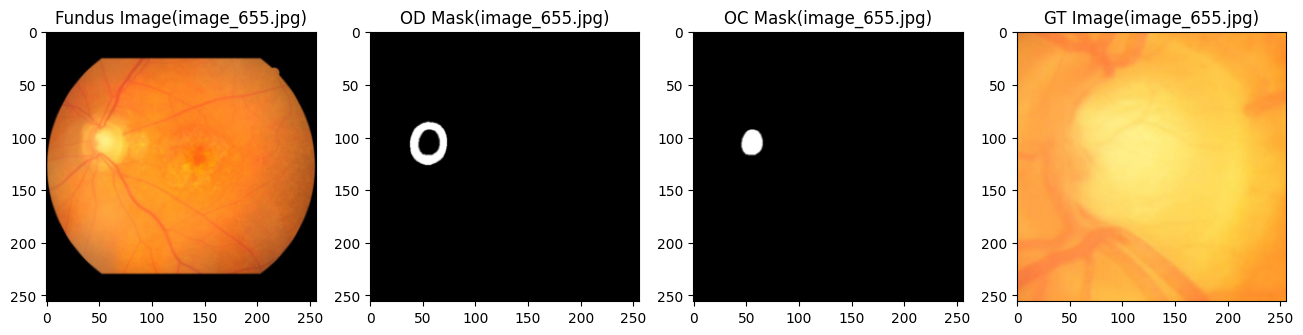

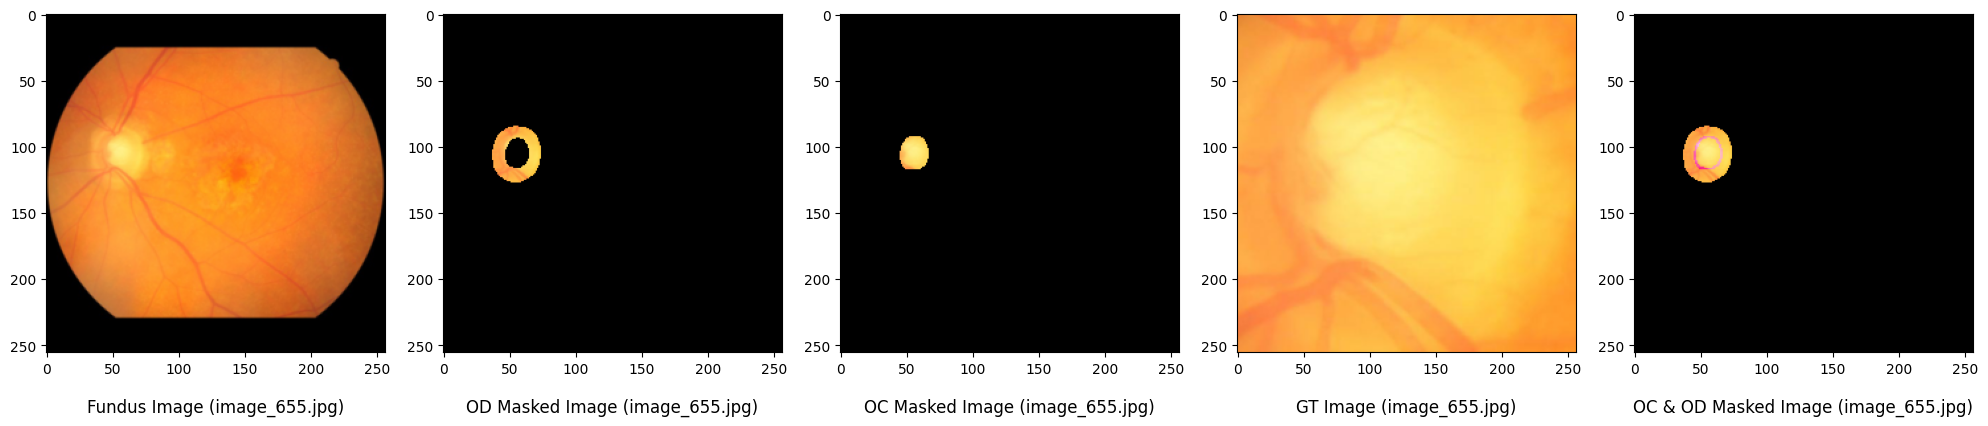

In [4]:
class GlaucomaMaskExtractor:
    def __init__(self, glaucoma_dataset):
        # Initialize with the dataset object
        self.glaucoma_dataset = glaucoma_dataset

    def apply_mask(self, fundus_image, mask):
        """Apply mask to fundus image and return the masked image."""
        # Ensure mask is binary (0 or 1)
        binary_mask = (mask > 0).astype(np.uint8)
        
        # Expand the mask to 3 channels (RGB), so it can be applied to the 3-channel fundus image
        binary_mask_rgb = np.stack([binary_mask] * 3, axis=-1)  # Shape: (H, W, 3)
        
        # Apply the mask by element-wise multiplication
        masked_image = fundus_image * binary_mask_rgb
        
        return masked_image

    def extract_od_oc(self, index):
        """Extract both OD and OC regions from the fundus image using the masks."""
        fundus_image = self.glaucoma_dataset.images[index]  # 원본 이미지
        od_mask = self.glaucoma_dataset.segs[index][0]  # OD (Optic Disc) 마스크
        oc_mask = self.glaucoma_dataset.segs[index][1]  # OC (Optic Cup) 마스크
        
        # Apply OD and OC masks
        od_image = self.apply_mask(fundus_image, od_mask)
        oc_image = self.apply_mask(fundus_image, oc_mask)
        od_and_oc_image = od_image + oc_image
        
        return fundus_image, od_image, oc_image, od_and_oc_image

    def show_images(self, index):
        """Display the fundus image, OD masked image, and OC masked image for a given index."""
        fundus_image, od_image, oc_image, od_and_oc_image = self.extract_od_oc(index)
        image_path = self.glaucoma_dataset.image_filenames[index]
        gt_image = self.glaucoma_dataset.gt_images[index]

        # Plot the images
        plt.figure(figsize=(20, 6))

        # Original Fundus Image
        plt.subplot(1, 5, 1)
        plt.imshow(fundus_image)
        plt.title(f'Fundus Image ({image_path})', y=-0.2)

        # OD Masked Image
        plt.subplot(1, 5, 2)
        plt.imshow(od_image)
        plt.title(f'OD Masked Image ({image_path})', y=-0.2)

        # OC Masked Image
        plt.subplot(1, 5, 3)
        plt.imshow(oc_image)
        plt.title(f'OC Masked Image ({image_path})', y=-0.2)

        # GT Image
        plt.subplot(1, 5, 4)
        plt.imshow(gt_image)
        plt.title(f'GT Image ({image_path})', y=-0.2)


        # OD and OC Masked Image
        plt.subplot(1, 5, 5)
        plt.imshow(od_and_oc_image)
        plt.title(f'OC & OD Masked Image ({image_path})', y=-0.2)

        plt.tight_layout()
        plt.show()

root_dir = ['/home/sunghun/midas_lab/learning/ssu/glaucoma-datases']

train_set = GlaucomaDataset(root_dir, split='train')
train_set.show_sample(0)

# Create an instance of the extractor with the GlaucomaDataset object
extractor = GlaucomaMaskExtractor(train_set)
# Index of the image you want to visualize
index = 0
# Show the images with the applied masks for the given index
extractor.show_images(index)


## Fundus Image, OD/OC Mask, masked image

각 파일이 어떤 내용을 의미하는지 먼저 확인합니다.
안저 이미지에서 시신경 유두, 시신경 컵을 구분하는 파일로 구성되어 있습니다. GT 데이터가 존재하는 상황인 만큼 supervised learning을 생각했습니다.
안저 이미지를 input으로, 안저 이미지에서 optic nerve disk, optic nerve cup을 segmentation 하는 task로 결정하였습니다.

Baseline 모델로 단순한 MLP 구조를 가진 모델을 생각했습니다. 비교하려는 모델로는 patch 기반의 MLP구조를 가진 모델로 결정했습니다. 

공간적인 정보를 가지지 않은 상황과, 가진 상황에 대해서 CNN을 적용하지 않은 상황에서의 성능이 궁금하여 설계를 진행하게 되었습니다. 

In [1]:
import numpy as np
import os
import cv2
from PIL import Image

# 이미지 input
# oc / od mask - prediction

# Code initialization
class GlaucomaDataset:
    def __init__(self, root_dir, split='train', output_size=(256, 256)):
        self.output_size = output_size
        self.root_dir = root_dir
        self.split = split
        self.images = []           # 원본 이미지
        self.image_filenames = []  # 이미지 파일 이름
        self.segs = []             # GT 마스크 (OD/OC)
        self.gt_images = []        # 정답 이미지 (GT)
        self.od_masked_images = [] # OD 마스크가 적용된 이미지 256 256 3
        self.oc_masked_images = [] # OC 마스크가 적용된 이미지 256 256 3

        # 데이터 로드
        for direct in self.root_dir:
            for path in os.listdir(os.path.join(direct, "Images_Square")):
                # 숨김 파일 무시
                if not path.startswith('.'):
                    self.image_filenames.append(path)

            # 이미지 및 마스크 로드
            for k in range(len(self.image_filenames)):
                print('Loading {} image {}/{}...'.format(split, k, len(self.image_filenames)), end='\r')
                img_name = os.path.join(direct, "Images_Square", self.image_filenames[k])
                img = np.array(Image.open(img_name).convert('RGB'))  # Load image as NumPy array
                img = self.resize_image(img, self.output_size)       # Resize image using NumPy
                self.images.append(img)

                print('Loading GT image {}/{}...'.format(split, k, len(self.image_filenames)), end='\r')
                gt_name = os.path.join(direct, "NerveRemoved_Images", self.image_filenames[k])
                gt_img = np.array(Image.open(gt_name).convert('RGB'))  # Load image as NumPy array
                gt_img = self.resize_image(gt_img, self.output_size)  # Resize image using NumPy
                self.gt_images.append(gt_img)

            # 마스크 (OD/OC) 로드
            if split != 'test':
                for k in range(len(self.image_filenames)):
                    print('Loading {} segmentation {}/{}...'.format(split, k, len(self.image_filenames)), end='\r')
                    seg_name = os.path.join(direct, "Masks_Square", self.image_filenames[k][:-3] + "png")
                    mask = np.array(Image.open(seg_name))  # Load mask as NumPy array
                    od = (mask == 1).astype(np.float32)    # 시신경 유두 마스크
                    oc = (mask == 2).astype(np.float32)    # 시신경 컵 마스크
                    od = self.resize_image(od, self.output_size)
                    oc = self.resize_image(oc, self.output_size)
                    self.segs.append(np.stack([od, oc], axis=-1))  # 256 256 2

                    # OD 및 OC 마스크가 적용된 이미지를 미리 생성하여 저장
                    od_masked_image = self.apply_mask(self.images[k], od)
                    oc_masked_image = self.apply_mask(self.images[k], oc)

                    self.od_masked_images.append(od_masked_image)
                    self.oc_masked_images.append(oc_masked_image)

            print('Successfully loaded {} dataset.'.format(split) + ' ' * 50)

    def __len__(self):
        return len(self.image_filenames)

    def resize_image(self, image, output_size):
        """Resize image to output_size using NumPy."""
        return np.array(Image.fromarray(image).resize(output_size, Image.BILINEAR))

    def apply_mask(self, image, mask):
        """Apply a mask to the RGB image."""
        mask_rgb = np.stack([mask] * 3, axis=-1)  # 마스크를 3채널로 확장
        masked_image = image * mask_rgb           # 원본 이미지에 마스크 적용
        return masked_image
    
    def get_od_oc_masked_images(self, index):
        """OD 및 OC 마스크가 적용된 이미지 반환."""
        if index >= len(self.images):
            raise IndexError("Index out of bounds")
        
        return self.images[index], self.od_masked_images[index], self.oc_masked_images[index]

# Example usage
root_dir = ['/home/sunghun/midas_lab/learning/ssu/glaucoma-datases']
dataset = GlaucomaDataset(root_dir, split='train')

index = 0
image, od_masked_image, oc_masked_image = dataset.get_od_oc_masked_images(index)

print("Image Shape:", image.shape)
print("OD Masked Image Shape:", od_masked_image.shape) # 256 256 3
print("OC Masked Image Shape:", oc_masked_image.shape) # 256 256 3

print("Preprocessing Completed!")



Successfully loaded train dataset.                                                  
Image Shape: (256, 256, 3)
OD Masked Image Shape: (256, 256, 3)
OC Masked Image Shape: (256, 256, 3)
Preprocessing Completed!


## 참고한 유틸 함수

아래는 참고한 함수 모음입니다. kaggle 웹사이트에서 참고한 함수이며 OC, OD segmentation 관련 metric을 찾던 중 cup/disk ratio를 활용한 지표가 있어 반영했습니다. 
참고한 함수에는 keras, pytorch 등의 프레임워크가 적용된 함수이며 numpy 버전으로 직접 변환해서 응용하였습니다. 

(https://www.kaggle.com/code/sexycode/glaucoma-detection-unet/edit) 참고

In [1]:
# 참고한 코드입니다 
# Util function (https://www.kaggle.com/code/sexycode/glaucoma-detection-unet/edit)


# 시신경을 제거하여 전처리된 이미지를 반환합니다
# 원본 이미지에서 시신경을 제거한 결과를 반환한다 
def remove_nerves(image):
    img = array_to_img(image)
    
    img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
    # convert image to grayScale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(17,17))
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)

    # inpaint with original image and threshold image
    final_image = cv2.inpaint(img,threshold,1,cv2.INPAINT_TELEA)
    final_image = cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    
    return final_image.astype(np.float64)/255.0

EPS = 1e-7

# 이미지 간 Dice 게수 계산해서 예측 세그먼테이션, 실제 세그멘테이션 간의 유사도를 측정한다
def compute_dice_coef(input, target):
    '''
    Compute dice score metric.
    '''
    batch_size = input.shape[0]
    return sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)])/batch_size

# 현 샘플에 대한 Dice 게수를 계산한다
# 실제, 예측을 모두 1차원으로 펼친 다음 벡터의 교집합 픽셀 수를 이용해서 DICE 계수를 계산한다. 이미지가 얼마나 일치하는지를 나태는 지표
# 1에 가까울수록 유사도가 높다 
def dice_coef_sample(input, target):
    iflat = input.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()
    return (2. * intersection) / (iflat.sum() + tflat.sum())

# binary segmentation map에서 세로 직경을 계산한다
def vertical_diameter(binary_segmentation):
    '''
    Get the vertical diameter from a binary segmentation.
    The vertical diameter is defined as the "fattest" area of the binary_segmentation parameter.
    '''

    # get the sum of the pixels in the vertical axis
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)

    # pick the maximum value
    diameter = np.max(vertical_axis_diameter, axis=1)

    # return it
    return diameter

# disk, cup의 세로 직경 비율을 계산한다
# main metric
def vertical_cup_to_disc_ratio(od, oc):
    '''
    Compute the vertical cup-to-disc ratio from a given labelling map.
    '''
    # compute the cup diameter
    cup_diameter = vertical_diameter(oc)
    # compute the disc diameter
    disc_diameter = vertical_diameter(od)

    return cup_diameter / (disc_diameter + EPS)

# Compare gt and predictions
def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    '''
    Compute vCDR prediction error, along with predicted vCDR and ground truth vCDR.
    '''
    pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
    gt_vCDR = vertical_cup_to_disc_ratio(gt_od, gt_oc)
    vCDR_err = np.mean(np.abs(gt_vCDR - pred_vCDR))
    return vCDR_err, pred_vCDR, gt_vCDR

# AUC (Area under Curve) 점수를 계산해서 분류 성능을 평가한다
def classif_eval(classif_preds, classif_gts):
    '''
    Compute AUC classification score.
    '''
    auc = roc_auc_score(classif_gts, classif_preds)
    return auc

# 세그멘테이션 맵에서 가장 큰 연결 성분만을 남겨 노이즈를 제거하는 함수
def refine_seg(pred):
    '''
    Only retain the biggest connected component of a segmentation map.
    '''
    np_pred = pred.numpy()
        
    largest_ccs = []
    for i in range(np_pred.shape[0]):
        labeled, ncomponents = label(np_pred[i,:,:])
        bincounts = np.bincount(labeled.flat)[1:]
        if len(bincounts) == 0:
            largest_cc = labeled == 0
        else:
            largest_cc = labeled == np.argmax(bincounts)+1
        largest_cc = torch.tensor(largest_cc, dtype=torch.float32)
        largest_ccs.append(largest_cc)
    largest_ccs = torch.stack(largest_ccs)
    
    return largest_ccs


In [2]:
# Util - numpy ver
# Numpy 버전으로 변형한 함수 
# 역할은 참고한 유틸 함수와 동일합니다 

EPS = 1e-7

def remove_nerves(image):
    # 이미지를 그레이스케일로 변환
    grayScale = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140])
    
    # 형태학적 변환을 위한 커널 생성
    kernel_size = 17
    kernel = np.ones((kernel_size, kernel_size), np.uint8)
    
    # MORPH_BLACKHAT 효과 적용 (blackhat = 원본 - 열림 연산)
    blackhat = grayScale - cv2_opening(grayScale, kernel)
    
    # 임계값 적용
    threshold = (blackhat > 10).astype(np.uint8) * 255
    
    # 이미지에서 신경 제거 (inpainting 대체)
    final_image = image.copy()
    final_image[threshold == 255] = [0, 0, 0]
    return final_image.astype(np.float64) / 255.0

def cv2_opening(image, kernel):
    """Numpy로 MORPH_OPEN과 비슷한 효과를 구현"""
    # 침식 연산
    eroded = binary_erosion(image, kernel)
    # 팽창 연산
    opened = binary_dilation(eroded, kernel)
    return opened

def binary_erosion(image, kernel):
    pad_size = kernel.shape[0] // 2
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    output_image = np.zeros_like(image)

    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            output_image[i, j] = np.min(region * kernel)
    return output_image

def binary_dilation(image, kernel):
    pad_size = kernel.shape[0] // 2
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    output_image = np.zeros_like(image)

    for i in range(output_image.shape[0]):
        for j in range(output_image.shape[1]):
            region = padded_image[i:i + kernel.shape[0], j:j + kernel.shape[1]]
            output_image[i, j] = np.max(region * kernel)
    return output_image

def compute_dice_coef(input, target):
    batch_size = input.shape[0]
    return np.sum([dice_coef_sample(input[k,:,:], target[k,:,:]) for k in range(batch_size)]) / batch_size

def dice_coef_sample(input, target):
    iflat = input.ravel()
    tflat = target.ravel()
    intersection = np.sum(iflat * tflat)
    return (2. * intersection) / (np.sum(iflat) + np.sum(tflat) + EPS)

def vertical_diameter(binary_segmentation):
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)
    diameter = np.max(vertical_axis_diameter)
    return diameter

def vertical_cup_to_disc_ratio(od, oc):
    cup_diameter = vertical_diameter(oc)
    disc_diameter = vertical_diameter(od)
    return cup_diameter / (disc_diameter + EPS)

def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    pred_vCDR = vertical_cup_to_disc_ratio(pred_od, pred_oc)
    gt_vCDR = vertical_cup_to_disc_ratio(gt_od, gt_oc)
    vCDR_err = np.mean(np.abs(gt_vCDR - pred_vCDR))
    return vCDR_err, pred_vCDR, gt_vCDR

def classif_eval(classif_preds, classif_gts):
    # Sort predictions and ground truths by the predicted probabilities
    sorted_indices = np.argsort(classif_preds)
    sorted_gts = np.array(classif_gts)[sorted_indices]
    sorted_preds = np.array(classif_preds)[sorted_indices]

    # Calculate True Positive and False Positive Rates
    tpr = np.cumsum(sorted_gts) / np.sum(sorted_gts)
    fpr = np.cumsum(1 - sorted_gts) / np.sum(1 - sorted_gts)

    # Calculate AUC using the Trapezoidal Rule
    auc = np.trapz(tpr, fpr)
    return auc

def refine_seg(pred):
    np_pred = pred.astype(np.int32)
    largest_ccs = []

    for i in range(np_pred.shape[0]):
        labeled, num_labels = label_connected_components(np_pred[i,:,:])
        bincounts = np.bincount(labeled.flat)
        
        if len(bincounts) > 1:
            largest_cc_label = np.argmax(bincounts[1:]) + 1
            largest_cc = (labeled == largest_cc_label).astype(np.float32)
        else:
            largest_cc = (labeled == 0).astype(np.float32)
            
        largest_ccs.append(largest_cc)

    return np.stack(largest_ccs)

def label_connected_components(image):
    labels = np.zeros_like(image, dtype=int)
    current_label = 1
    
    # 좌표를 저장해 방문하여 연결된 구성 요소를 찾기 위한 스택
    stack = []
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] == 1 and labels[i, j] == 0:
                stack.append((i, j))
                while stack:
                    x, y = stack.pop()
                    if labels[x, y] == 0:
                        labels[x, y] = current_label
                        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                            nx, ny = x + dx, y + dy
                            if 0 <= nx < image.shape[0] and 0 <= ny < image.shape[1] and image[nx, ny] == 1 and labels[nx, ny] == 0:
                                stack.append((nx, ny))
                current_label += 1
                
    return labels, current_label - 1

## Baseline code - Simple MLP

단순 MLP구조를 가진 모델을 설계했습니다. 
입력 레이어 - 히든 레이어 - 출력 레이어로 구성되어 있습니다. 

In [23]:
# MLP Configuration
class MLP:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.weights1 = np.random.randn(input_size, hidden_size) * 0.01  # input to hidden layer
        self.bias1 = np.zeros((1, hidden_size))  # hidden layer bias
        self.weights2 = np.random.randn(hidden_size, output_size) * 0.01  # hidden to output layer
        self.bias2 = np.zeros((1, output_size))  # output layer bias

    def relu(self, x):
        """ReLU activation function"""
        return np.maximum(0, x)

    def forward(self, x):
        """Forward pass for MLP"""
        # Flatten the input (batch_size, 256*256*3)
        x = x.reshape(x.shape[0], -1)  # Flatten input, shape (batch_size, input_size)

        # Forward pass through the first layer
        hidden_layer = np.dot(x, self.weights1) + self.bias1
        hidden_layer = self.relu(hidden_layer)  # Apply ReLU activation

        # Forward pass through the output layer (predict OD/OC masks)
        output_layer = np.dot(hidden_layer, self.weights2) + self.bias2

        # Reshape output to (batch_size, 256, 256, 2) for OD and OC masks
        output_layer = output_layer.reshape(x.shape[0], 256, 256, 2)
        return output_layer
    
    # MSE에서 벗어나 추가적인 loss함수를 구성해볼까? 라는 생각에서 나온 Loss들 (dice_loss, binary_cross_entropy_loss)
    def dice_loss(self, predictions, targets):
        """Dice Loss for binary segmentation"""
        smooth = 1e-7  # Small constant to avoid division by zero
        intersection = np.sum(predictions * targets)
        dice_coef = (2. * intersection + smooth) / (np.sum(predictions) + np.sum(targets) + smooth)
        return 1 - dice_coef
    
    # 추가된 loss 유형
    def binary_cross_entropy_loss(self, predictions, targets):
        """Binary Cross-Entropy Loss for segmentation"""
        epsilon = 1e-7  # Small constant to avoid log(0)
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        return -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))
    
    def compute_loss(self, predictions, targets):
        """Mean Squared Error Loss"""
        return self.binary_cross_entropy_loss(predictions, targets)

    def train_step(self, x, y, learning_rate=0.001):
        """Single training step with forward pass, loss computation, and weight update"""
        # Forward pass
        predictions = self.forward(x)

        # Compute loss
        loss = self.compute_loss(predictions, y)

        # Compute gradients (backpropagation)
        grad_output = 2 * (predictions - y) / y.size  # Gradient of MSE loss

        # Backpropagation for weights2 and bias2
        hidden_layer = np.dot(x.reshape(x.shape[0], -1), self.weights1) + self.bias1
        hidden_layer = self.relu(hidden_layer)
        grad_w2 = np.dot(hidden_layer.T, grad_output.reshape(grad_output.shape[0], -1))
        grad_b2 = np.sum(grad_output, axis=0)

        # Backpropagation for weights1 and bias1
        grad_hidden = np.dot(grad_output.reshape(grad_output.shape[0], -1), self.weights2.T)
        grad_hidden[hidden_layer <= 0] = 0  # ReLU gradient

        grad_w1 = np.dot(x.reshape(x.shape[0], -1).T, grad_hidden)
        grad_b1 = np.sum(grad_hidden, axis=0)

        # Update weights and biases
        self.weights2 -= learning_rate * grad_w2
        self.bias2 -= learning_rate * grad_b2.reshape(1, -1)
        self.weights1 -= learning_rate * grad_w1
        self.bias1 -= learning_rate * grad_b1.reshape(1, -1)

        return loss

In [24]:
def train_model(mlp, x_train, y_train, learning_rate=0.001):
    """
    Train the model for one forward pass and return the training loss.
    """
    # Forward pass and weight update for a single step
    train_loss = mlp.train_step(x_train, y_train, learning_rate)
    return train_loss


def validate_model(mlp, x_val, y_val):
    """
    Validate the model on validation data and return validation loss.
    """
    predictions = mlp.forward(x_val)
    val_loss = mlp.compute_loss(predictions, y_val)
    return val_loss


def test_model(mlp, x_test, y_test):
    """
    Test the model on test data and return test loss.
    """
    predictions = mlp.forward(x_test)
    test_loss = mlp.compute_loss(predictions, y_test)
    return test_loss

In [25]:
# 2. OD 및 OC 마스크 예측
def predict_masks(model, image):
    """이미지를 입력받아 OD 및 OC 마스크를 예측"""
    image_input = image.reshape(1, *image.shape)  # 모델에 맞게 차원 추가
    predicted_masks = model.forward(image_input)  # 모델을 통해 예측
    od_mask, oc_mask = predicted_masks[0, :, :, 0], predicted_masks[0, :, :, 1]  # OD와 OC 마스크 분리
    return od_mask, oc_mask

def run_epoch(mlp, x_train, y_train, x_val, y_val, x_test, y_test, learning_rate=0.001):
    """
    Run one epoch of train, validate, and test, and return the losses.
    """
    # Train the model and get training loss
    train_loss = train_model(mlp, x_train, y_train, learning_rate)

    # Validate the model and get validation loss
    val_loss = validate_model(mlp, x_val, y_val)

    # Calculate vCDR error for the first sample in the validation set
    pred_od_mask, pred_oc_mask = predict_masks(mlp, x_val[0])  # Use first validation sample
    gt_od_mask, gt_oc_mask = y_val[0, :, :, 0], y_val[0, :, :, 1]  # Ground truth OD and OC masks

    # Compute vCDR error for validation
    vCDR_err, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od_mask, pred_oc_mask, gt_od_mask, gt_oc_mask)
    print(f"Validation vCDR Error: {vCDR_err}, Predicted vCDR: {pred_vCDR}, Ground Truth vCDR: {gt_vCDR}")

    return train_loss, val_loss, vCDR_err  # Return the vCDR error as well

def k_fold_cross_validation(dataset, k=5, hidden_size=128, learning_rate=0.001, epochs=10, print_every=2):
    """K-Fold Cross Validation for MLP model with epoch-based train/validate/test"""
    kfold = KFold(n_splits=k, shuffle=True)
    fold_idx = 1
    best_model = None
    best_val_loss = float('inf')

    images = np.array(dataset.images) # Convert images
    segs = np.array(dataset.segs) # Convert segs 

    for train_index, test_index in kfold.split(dataset.images):
        print(f"Fold {fold_idx}:")

        # Split the data into training, validation, and test sets
        x_train, x_test = images[train_index], images[test_index]
        y_train, y_test = segs[train_index], segs[test_index]

        # Further split train set into training and validation sets (80% train, 20% val)
        val_split = int(len(x_train) * 0.8)
        x_val, y_val = x_train[val_split:], y_train[val_split:]
        x_train, y_train = x_train[:val_split], y_train[:val_split]

        # Initialize the MLP model once, outside of the epoch loop
        input_size = x_train.shape[1] * x_train.shape[2] * x_train.shape[3]  # Flatten size (256*256*3)
        output_size = y_train.shape[1] * y_train.shape[2] * 2  # Flatten size (256*256*2 for OD/OC)
        
        # Select one model
        mlp = MLP(input_size, hidden_size, output_size)
        # mlp = PatchBasedMLP(input_size, hidden_size, output_size)
        
        # Track losses for each epoch
        for epoch in range(epochs):
            # Run one epoch of training, validation, and testing
            train_loss, val_loss, vCDR_err = run_epoch(mlp, x_train, y_train, x_val, y_val, x_test, y_test, learning_rate)
            
            # Save the model if it has the best validation loss so far
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(mlp)  # Save the best model's state

            # Print the losses at specified intervals
            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Validation vCDR Error: {vCDR_err}")
            
        print("Training finished. Best validation loss:", best_val_loss)

        # Save the best model using pickle
        with open('best_model.pkl', 'wb') as f:
            pickle.dump(best_model, f)

        with open('best_model.pkl', 'rb') as f:
            loaded_model = pickle.load(f)
        
        # Test the best model on the test data and calculate vCDR error
        test_loss = test_model(loaded_model, x_test, y_test)
        pred_od_mask, pred_oc_mask = predict_masks(loaded_model, x_test[0])  # Using the first test sample for vCDR calculation
        gt_od_mask, gt_oc_mask = y_test[0, :, :, 0], y_test[0, :, :, 1]  # Ground truth OD and OC masks
        
        # Compute the vCDR error for the test data
        test_vCDR_err, pred_test_vCDR, gt_test_vCDR = compute_vCDR_error(pred_od_mask, pred_oc_mask, gt_od_mask, gt_oc_mask)
        
        print(f"Final test loss with the best model: {test_loss}")
        print(f"Test vCDR Error: {test_vCDR_err}, Predicted vCDR: {pred_test_vCDR}, Ground Truth vCDR: {gt_test_vCDR}")
        
        fold_idx += 1

### Baseline 모델 실행 결과

vCDR 지표를 활용해서 결과를 확인해보았습니다.
단순 MLP로 구성된 모델의 경우 크기가 낮은 경우도, 높은 경우 모두 존재했습니다. 다만 범위가 일정치 못하고 편차가 다소 심한 결과를 확인할 수 있습니다. 

- MIN : 0.150582475967027
- MAX : 0.9219963278062865


In [26]:
np.random.seed(42)

root_dir = ['/home/sunghun/midas_lab/learning/ssu/glaucoma-datases']
dataset = GlaucomaDataset(root_dir, split='train')

Successfully loaded train dataset.                                                  


In [27]:
k_fold_cross_validation(dataset, k=5, hidden_size=128, learning_rate=0.001, epochs=10, print_every=5)

Fold 1:
Validation vCDR Error: 0.39797257122745694, Predicted vCDR: 0.8478814952350083, Ground Truth vCDR: 0.4499089240075514
Validation vCDR Error: 0.393398281880101, Predicted vCDR: 0.8433072058876524, Ground Truth vCDR: 0.4499089240075514
Validation vCDR Error: 0.38888823975460923, Predicted vCDR: 0.8387971637621606, Ground Truth vCDR: 0.4499089240075514
Validation vCDR Error: 0.384434233382516, Predicted vCDR: 0.8343431573900674, Ground Truth vCDR: 0.4499089240075514
Validation vCDR Error: 0.38003179536579285, Predicted vCDR: 0.8299407193733442, Ground Truth vCDR: 0.4499089240075514
Epoch 5/10, Train Loss: 0.12362112155363021, Val Loss: 0.1295713145119974, Validation vCDR Error: 0.38003179536579285
Validation vCDR Error: 0.37567821773055404, Predicted vCDR: 0.8255871417381054, Ground Truth vCDR: 0.4499089240075514
Validation vCDR Error: 0.3713717067399242, Predicted vCDR: 0.8212806307474756, Ground Truth vCDR: 0.4499089240075514
Validation vCDR Error: 0.3671109419279836, Predicted 

### Baseline 모델 결과 Visualization 

아래의 코드는 Baseline 모델에서 예측한 마스크 정보를 활용해서 시각화하는 과정입니다.

다만 도출된 마스크 정보에서 어떤 범위 내의 값을 Optic nerve disk, Optic nerve cup으로 설정해야할지에 대해서 고민했습니다.
현재는 Hyper parameter 형태처럼 직접 값을 넣은 상황이지만, 어떻게 하면 더 효과적으로 구분할 수 있을지에 대해서는 더 생각해야 한다고 생각합니다. 

실제로 현재 설정한 값의 범위에는 속한 값이 존재하지 않은 것도 확인할 수 있습니다.

GT 마스크 정보를 확인하면 1 - OD, 2- OC로 구성되어 있는 상황인데 이에 대한 모델의  결과를 확인하면 단순하게 1, 2 로 예측을 하는 것이 아닌 소수점 형태로 진행하는 만큼
어떤 범위를 OD로 할지 OC로 할지에 대해서 더 구체적으로 생각해야 할 듯 합니다. 

OD와 OC 마스크 범위에 해당하지 않는 값의 개수: 16711680
OD Mask 활성화된 값의 개수: 0
OC Mask 활성화된 값의 개수: 0
(256, 256) (256, 256)


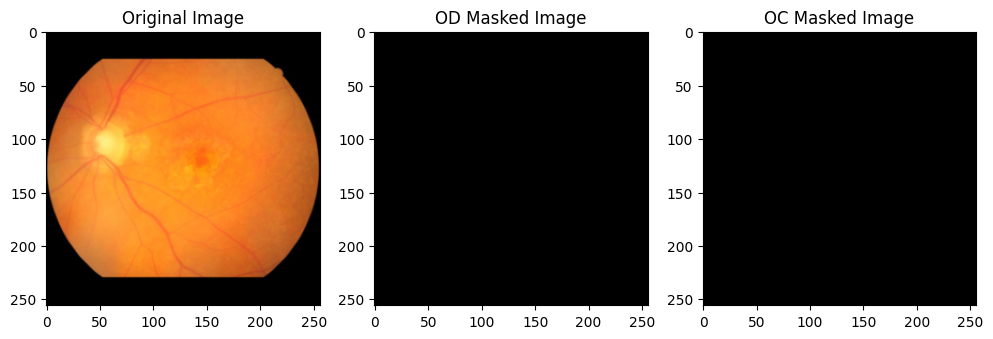

In [22]:
# Predicted masks - visualization
def load_model(model_path='best_model.pkl'):
    with open(model_path, 'rb') as f:
        best_model = pickle.load(f)
    return best_model

# 2. OD 및 OC 마스크 예측
def predict_masks(model, image):
    """이미지를 입력받아 OD 및 OC 마스크를 예측"""
    image_input = image.reshape(1, *image.shape)  # 모델에 맞게 차원 추가
    predicted_masks = model.forward(image_input)  # 모델을 통해 예측
    od_mask, oc_mask = predicted_masks[0, :, :, 0], predicted_masks[0, :, :, 1]  # OD와 OC 마스크 분리
    return od_mask, oc_mask

# 3. 마스크 적용
def apply_masks_to_image(image, od_mask, oc_mask):
    """원본 이미지에 OD와 OC 마스크를 적용하여 RGB 이미지로 변환"""
    # od_mask는 0.5 - 1.5 범위의 값으로 설정
    binary_od_mask = ((od_mask >= 0.5) & (od_mask <= 1.5)).astype(np.uint8)
    
    # oc_mask는 1.5 - 2.5 범위의 값으로 설정
    binary_oc_mask = ((oc_mask > 1.5) & (oc_mask <= 2.5)).astype(np.uint8)

    # 활성화된 값의 개수를 계산
    od_active_count = np.sum(binary_od_mask)
    oc_active_count = np.sum(binary_oc_mask)
    # OD와 OC 마스크 모두에 해당하지 않는 부분을 계산
    non_active_count = np.sum(~(binary_od_mask | binary_oc_mask))

    print(f"OD와 OC 마스크 범위에 해당하지 않는 값의 개수: {non_active_count}")
    print(f"OD Mask 활성화된 값의 개수: {od_active_count}")
    print(f"OC Mask 활성화된 값의 개수: {oc_active_count}")

    # Expand the mask to 3 channels (RGB), so it can be applied to the 3-channel fundus image
    binary_od_mask_rgb = np.stack([binary_od_mask] * 3, axis=-1)  # Shape: (H, W, 3)
    binary_oc_mask_rgb = np.stack([binary_oc_mask] * 3, axis=-1)
    
    od_masked_image = image * binary_od_mask_rgb  # 원본 이미지에 OD 마스크 적용
    oc_masked_image = image * binary_oc_mask_rgb  # 원본 이미지에 OC 마스크 적용
    
    return od_masked_image, oc_masked_image

# 4. 시각화
def show_result(image, od_masked_image, oc_masked_image):
    """원본 이미지와 OD/OC 마스크가 적용된 이미지를 시각화"""
    plt.figure(figsize=(12, 6))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    
    # OD 마스크가 적용된 이미지
    plt.subplot(1, 3, 2)
    plt.imshow(od_masked_image)
    plt.title("OD Masked Image")
    
    # OC 마스크가 적용된 이미지
    plt.subplot(1, 3, 3)
    plt.imshow(oc_masked_image)
    plt.title("OC Masked Image")
    
    plt.show()

sample_image, _, _ = dataset.get_od_oc_masked_images(0)
# 모델 로드
best_model = load_model('best_model.pkl')

# OD/OC 마스크 예측
pred_od_mask, pred_oc_mask = predict_masks(best_model, sample_image)

# 마스크를 이미지에 적용
pred_od_masked_image, pred_oc_masked_image = apply_masks_to_image(image, pred_od_mask, pred_oc_mask)

# 결과 시각화
show_result(image, pred_od_masked_image, pred_oc_masked_image)

## Patch 기반 MLP 모델 구성

이미지를 patch로 구분하여 각 패치별로 feature map을 추출하면 어떨까하는 생각이 들었습니다.
이미지를 구분하고 각 패치의 이미지 정보를 활용하는 MLP 구조를 고려해보았습니다. 

구체적인 방법론은 보고서에 명시했습니다. 

In [9]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import KFold
import copy

# Define vCDR calculation function
def vertical_diameter(binary_segmentation):
    """Calculate the vertical diameter from a binary segmentation."""
    vertical_axis_diameter = np.sum(binary_segmentation, axis=1)
    diameter = np.max(vertical_axis_diameter)
    return diameter

def compute_vCDR(od, oc):
    """Calculate the vCDR ratio based on OD and OC masks."""
    cup_diameter = vertical_diameter(oc)
    disc_diameter = vertical_diameter(od)
    return cup_diameter / (disc_diameter + 1e-7)  # Avoid division by zero

def compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc):
    """Calculate the vCDR error between prediction and ground truth."""
    pred_vCDR = compute_vCDR(pred_od, pred_oc)
    gt_vCDR = compute_vCDR(gt_od, gt_oc)
    vCDR_error = np.abs(pred_vCDR - gt_vCDR)
    return vCDR_error, pred_vCDR, gt_vCDR

class PatchBasedMLP:
    def __init__(self, patch_size=(16, 16), hidden_size=128, output_size=(256, 256, 2)):
        self.patch_size = patch_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        # 각 패치에 대한 가중치와 편향 초기화
        self.weights = np.random.randn(patch_size[0] * patch_size[1] * 3, hidden_size) * 0.01
        self.bias = np.zeros((1, hidden_size))
        # Output weights are sized to output a flattened patch with 2 channels (OD and OC mask predictions)
        self.output_weights = np.random.randn(hidden_size, patch_size[0] * patch_size[1] * 2) * 0.01
        self.output_bias = np.zeros((1, patch_size[0] * patch_size[1] * 2))

    def relu(self, x):
        return np.maximum(0, x)

    def forward(self, image):
        h, w, _ = image.shape
        ph, pw = self.patch_size
        out_h, out_w = h // ph, w // pw
        output = np.zeros((out_h, out_w, ph, pw, 2))  # Initialize to store output patches

        for i in range(out_h):
            for j in range(out_w):
                patch = image[i*ph:(i+1)*ph, j*pw:(j+1)*pw].reshape(1, -1)  # 패치를 1D로 펼치기
                hidden = self.relu(np.dot(patch, self.weights) + self.bias)  # 패치에 대한 MLP 처리
                output_patch = np.dot(hidden, self.output_weights) + self.output_bias
                output_patch = output_patch.reshape(ph, pw, 2)  # Reshape to match patch size
                output[i, j] = output_patch

        # 패치 결과를 원본 이미지 크기(256, 256, 2)로 복원
        output_resized = output.transpose(0, 2, 1, 3, 4).reshape(h, w, 2)
        return output_resized

    def compute_loss(self, predictions, targets):
        """Binary Cross-Entropy Loss for segmentation"""
        epsilon = 1e-7  # Small constant to avoid log(0)
        predictions = np.clip(predictions, epsilon, 1 - epsilon)
        return -np.mean(targets * np.log(predictions) + (1 - targets) * np.log(1 - predictions))

    def train_step(self, x, y, learning_rate=0.001):
        """Single training step with forward pass, loss computation, and weight update"""
        h, w, _ = x.shape
        ph, pw = self.patch_size
        out_h, out_w = h // ph, w // pw
        loss = 0

        # Iterate over each patch
        for i in range(out_h):
            for j in range(out_w):
                # Extract and flatten the patch
                patch = x[i*ph:(i+1)*ph, j*pw:(j+1)*pw].reshape(1, -1)
                target_patch = y[i*ph:(i+1)*ph, j*pw:(j+1)*pw].reshape(1, -1)

                # Forward pass for the patch
                hidden_layer = self.relu(np.dot(patch, self.weights) + self.bias)
                output_layer = np.dot(hidden_layer, self.output_weights) + self.output_bias

                # Calculate loss for this patch
                patch_loss = self.compute_loss(output_layer, target_patch)
                loss += patch_loss

                # Backpropagation for output weights and biases
                grad_output = (output_layer - target_patch) / target_patch.size
                grad_w2 = np.dot(hidden_layer.T, grad_output)
                grad_b2 = np.sum(grad_output, axis=0)

                # Backpropagation for weights and biases of the hidden layer
                grad_hidden = np.dot(grad_output, self.output_weights.T)
                grad_hidden[hidden_layer <= 0] = 0  # Apply ReLU gradient

                grad_w1 = np.dot(patch.T, grad_hidden)
                grad_b1 = np.sum(grad_hidden, axis=0)

                # Update weights and biases
                self.output_weights -= learning_rate * grad_w2
                self.output_bias -= learning_rate * grad_b2.reshape(1, -1)
                self.weights -= learning_rate * grad_w1
                self.bias -= learning_rate * grad_b1.reshape(1, -1)

        # Return average loss over all patches
        return loss / (out_h * out_w)

# Update validate_model and test_model to output vCDR error
def validate_model(mlp, x_val, y_val):
    val_loss = 0
    vCDR_errors = []
    for x, y in zip(x_val, y_val):
        predictions = mlp.forward(x)
        loss = mlp.compute_loss(predictions, y)
        val_loss += loss

        # Compute vCDR error
        pred_od, pred_oc = predictions[:, :, 0], predictions[:, :, 1]
        gt_od, gt_oc = y[:, :, 0], y[:, :, 1]
        vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc)
        vCDR_errors.append(vCDR_error)
    
    avg_vCDR_error = np.mean(vCDR_errors)
    print(f"Validation vCDR Error: {avg_vCDR_error}")
    return val_loss / len(x_val), avg_vCDR_error

def test_model(mlp, x_test, y_test):
    test_loss = 0
    vCDR_errors = []
    for x, y in zip(x_test, y_test):
        predictions = mlp.forward(x)
        loss = mlp.compute_loss(predictions, y)
        test_loss += loss

        # Compute vCDR error
        pred_od, pred_oc = predictions[:, :, 0], predictions[:, :, 1]
        gt_od, gt_oc = y[:, :, 0], y[:, :, 1]
        vCDR_error, pred_vCDR, gt_vCDR = compute_vCDR_error(pred_od, pred_oc, gt_od, gt_oc)
        vCDR_errors.append(vCDR_error)
    
    avg_vCDR_error = np.mean(vCDR_errors)
    print(f"Test vCDR Error: {avg_vCDR_error}")
    return test_loss / len(x_test), avg_vCDR_error

# Modify k_fold_cross_validation to include vCDR error in validation and testing stages
def k_fold_cross_validation(dataset, k=5, hidden_size=128, learning_rate=0.001, epochs=10, print_every=2):
    kfold = KFold(n_splits=k, shuffle=True)
    fold_idx = 1

    for train_index, test_index in kfold.split(dataset.images):
        print(f"Fold {fold_idx}:")
        x_train, x_test = np.array(dataset.images)[train_index], np.array(dataset.images)[test_index]
        y_train, y_test = np.array(dataset.segs)[train_index], np.array(dataset.segs)[test_index]

        # Split train set into training and validation sets
        val_split = int(len(x_train) * 0.8)
        x_val, y_val = x_train[val_split:], y_train[val_split:]
        x_train, y_train = x_train[:val_split], y_train[:val_split]

        mlp = PatchBasedMLP(patch_size=(16, 16), hidden_size=hidden_size, output_size=(256, 256, 2))

        best_val_loss = float('inf')
        for epoch in range(epochs):
            train_loss = train_model(mlp, x_train, y_train, learning_rate)
            val_loss, val_vCDR_error = validate_model(mlp, x_val, y_val)
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model = copy.deepcopy(mlp)

            if (epoch + 1) % print_every == 0:
                print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Val Loss: {val_loss}, Val vCDR Error: {val_vCDR_error}")
        
        print("Best Validation Loss:", best_val_loss)
        test_loss, test_vCDR_error = test_model(best_model, x_test, y_test)
        print(f"Final Test Loss: {test_loss}, Test vCDR Error: {test_vCDR_error}")
        
        fold_idx += 1

np.random.seed(42)

root_dir = ['/home/sunghun/midas_lab/learning/ssu/glaucoma-datases']
dataset = GlaucomaDataset(root_dir, split='train')
k_fold_cross_validation(dataset, k=5, hidden_size=128, learning_rate=0.001, epochs=10, print_every=5)

Successfully loaded train dataset.                                                  
Fold 1:
Validation vCDR Error: 0.28066875327821283
Validation vCDR Error: 0.2990228001042154
Validation vCDR Error: 0.3030977665619242
Validation vCDR Error: 0.3045200231496213
Validation vCDR Error: 0.30523585587668156
Epoch 5/10, Train Loss: 0.04509119116420584, Val Loss: 0.04539675494674609, Val vCDR Error: 0.30523585587668156
Validation vCDR Error: 0.30566814387296276
Validation vCDR Error: 0.3059388961062325
Validation vCDR Error: 0.3061134101317028
Validation vCDR Error: 0.30622518877340726
Validation vCDR Error: 0.30631359268591385
Epoch 10/10, Train Loss: 0.04483450485068146, Val Loss: 0.04521315262329924, Val vCDR Error: 0.30631359268591385
Best Validation Loss: 0.04521315262329924
Test vCDR Error: 0.2873143333138861
Final Test Loss: 0.04522303109806323, Test vCDR Error: 0.2873143333138861
Fold 2:
Validation vCDR Error: 0.26595818447339237
Validation vCDR Error: 0.2904993621584843
Validation v

In [ ]:
# Predicted masks - visualization
def load_model(model_path='best_model.pkl'):
    with open(model_path, 'rb') as f:
        best_model = pickle.load(f)
    return best_model

# 2. OD 및 OC 마스크 예측
def predict_masks(model, image):
    """이미지를 입력받아 OD 및 OC 마스크를 예측"""
    image_input = image.reshape(1, *image.shape)  # 모델에 맞게 차원 추가
    predicted_masks = model.forward(image_input)  # 모델을 통해 예측
    od_mask, oc_mask = predicted_masks[0, :, :, 0], predicted_masks[0, :, :, 1]  # OD와 OC 마스크 분리
    return od_mask, oc_mask

# 3. 마스크 적용
def apply_masks_to_image(image, od_mask, oc_mask):
    """원본 이미지에 OD와 OC 마스크를 적용하여 RGB 이미지로 변환"""
    # od_mask는 0.5 - 1.5 범위의 값으로 설정
    binary_od_mask = ((od_mask >= 0.5) & (od_mask <= 1.5)).astype(np.uint8)
    
    # oc_mask는 1.5 - 2.5 범위의 값으로 설정
    binary_oc_mask = ((oc_mask > 1.5) & (oc_mask <= 2.5)).astype(np.uint8)

    # 활성화된 값의 개수를 계산
    od_active_count = np.sum(binary_od_mask)
    oc_active_count = np.sum(binary_oc_mask)
    # OD와 OC 마스크 모두에 해당하지 않는 부분을 계산
    non_active_count = np.sum(~(binary_od_mask | binary_oc_mask))

    print(f"OD와 OC 마스크 범위에 해당하지 않는 값의 개수: {non_active_count}")
    print(f"OD Mask 활성화된 값의 개수: {od_active_count}")
    print(f"OC Mask 활성화된 값의 개수: {oc_active_count}")

    # Expand the mask to 3 channels (RGB), so it can be applied to the 3-channel fundus image
    binary_od_mask_rgb = np.stack([binary_od_mask] * 3, axis=-1)  # Shape: (H, W, 3)
    binary_oc_mask_rgb = np.stack([binary_oc_mask] * 3, axis=-1)
    
    od_masked_image = image * binary_od_mask_rgb  # 원본 이미지에 OD 마스크 적용
    oc_masked_image = image * binary_oc_mask_rgb  # 원본 이미지에 OC 마스크 적용
    
    return od_masked_image, oc_masked_image

# 4. 시각화
def show_result(image, od_masked_image, oc_masked_image):
    """원본 이미지와 OD/OC 마스크가 적용된 이미지를 시각화"""
    plt.figure(figsize=(12, 6))
    
    # 원본 이미지
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Original Image")
    
    # OD 마스크가 적용된 이미지
    plt.subplot(1, 3, 2)
    plt.imshow(od_masked_image)
    plt.title("OD Masked Image")
    
    # OC 마스크가 적용된 이미지
    plt.subplot(1, 3, 3)
    plt.imshow(oc_masked_image)
    plt.title("OC Masked Image")
    
    plt.show()

sample_image, _, _ = dataset.get_od_oc_masked_images(0)
# 모델 로드
best_model = load_model('best_model.pkl')

# OD/OC 마스크 예측
pred_od_mask, pred_oc_mask = predict_masks(best_model, sample_image)

# 마스크를 이미지에 적용
pred_od_masked_image, pred_oc_masked_image = apply_masks_to_image(image, pred_od_mask, pred_oc_mask)

# 결과 시각화
show_result(image, pred_od_masked_image, pred_oc_masked_image)